In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, AvgPool2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
train_dir="D:\\AI Project\\Brain Tumor\\data\\Train"
test_dir="D:\\AI Project\\Brain Tumor\\data\\Test"

datagn=ImageDataGenerator(rescale=1/255,validation_split=0.2,zoom_range=.7,shear_range=.2,rotation_range=.3)
test_datagn=ImageDataGenerator(rescale=1/255)


train_set=datagn.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=4,
    class_mode="categorical",
    subset="training"
    )

valid_set=datagn.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=4,
    class_mode="categorical",
    subset="validation"
)

test_set=test_datagn.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode="categorical"
)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [4]:
from keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')  # Uses float16 for calculations where possible

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Laptop GPU, compute capability 8.6


In [5]:
train_set.class_indices

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [6]:
labels=['glioma','meningioma','Normal','pituitary']
print(labels)

['glioma', 'meningioma', 'Normal', 'pituitary']


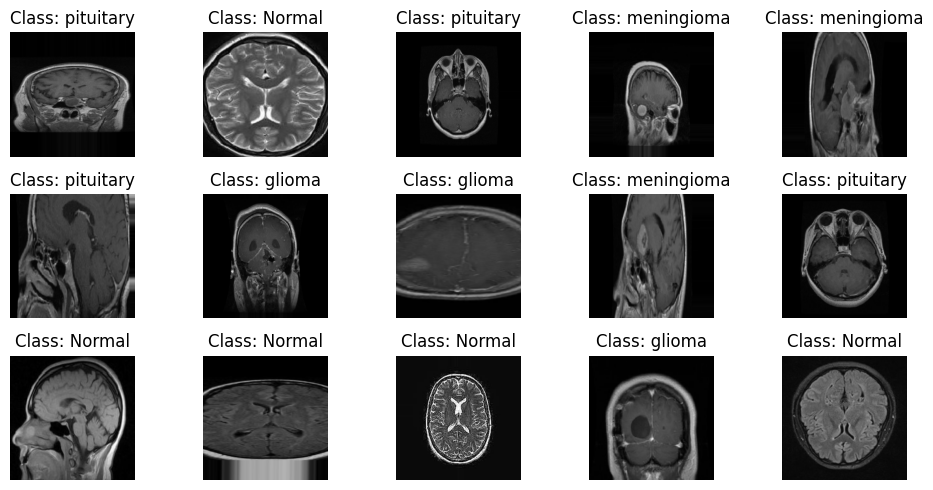

In [7]:
plt.figure(figsize=(10, 5))

for i in range(15):  
    plt.subplot(3, 5, i+1) 
    image, label = train_set.next()  
    plt.imshow(image[0])  
    plt.axis("off")  
    plt.title(f"Class: {labels[np.argmax(label)]}") 

plt.tight_layout()  
plt.show()

In [20]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in base_model.layers:
    layer.trainable = False

# Add new top layers for our specific classification problem
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x=Dropout(.3)(x)
x = Dense(4, activation='softmax')(x)

In [21]:
# Compile the model
model = Model(inputs=base_model.input, outputs=x)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_set,
                    epochs=30,
                    validation_data=valid_set,
                    verbose=1)

print("Training accuracy:", history.history['accuracy'][-1])
print("Validation accuracy:", history.history['val_accuracy'][-1])

Epoch 1/30
1143/1143 [==============================] - 42s 36ms/step - loss: 1.1132 - accuracy: 0.6401 - val_loss: 1.0147 - val_accuracy: 0.5495
Epoch 2/30
1143/1143 [==============================] - 42s 36ms/step - loss: 0.6646 - accuracy: 0.7283 - val_loss: 0.9613 - val_accuracy: 0.6433
Epoch 3/30
1143/1143 [==============================] - 43s 37ms/step - loss: 0.5852 - accuracy: 0.7657 - val_loss: 0.8601 - val_accuracy: 0.6950
Epoch 4/30
1143/1143 [==============================] - 42s 36ms/step - loss: 0.5453 - accuracy: 0.7790 - val_loss: 0.9122 - val_accuracy: 0.6670
Epoch 5/30
1143/1143 [==============================] - 42s 37ms/step - loss: 0.5368 - accuracy: 0.7880 - val_loss: 0.7354 - val_accuracy: 0.7169
Epoch 6/30
1143/1143 [==============================] - 43s 38ms/step - loss: 0.4939 - accuracy: 0.8005 - val_loss: 0.8093 - val_accuracy: 0.6477
Epoch 7/30
1143/1143 [==============================] - 43s 37ms/step - loss: 0.4915 - accuracy: 0.8066 - val_loss: 0.7720 -

In [22]:
test_loss,test_acc=model.evaluate(test_set)
print(test_acc)

41/41 [==============================] - 4s 84ms/step - loss: 0.4729 - accuracy: 0.8528
0.8527841567993164


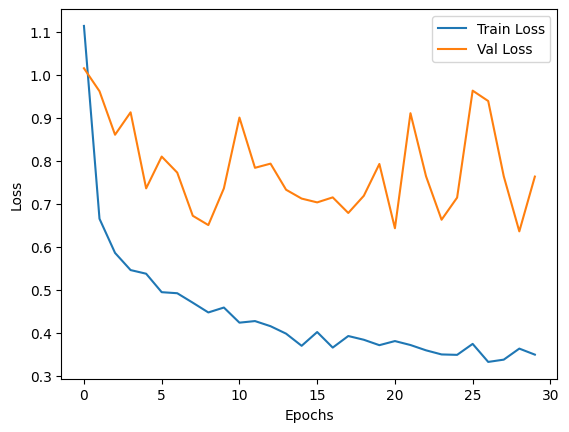

In [23]:
plt.plot(history.history['loss'], label = 'Train Loss')
plt.plot(history.history['val_loss'], label = 'Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc = 'best')
plt.show()

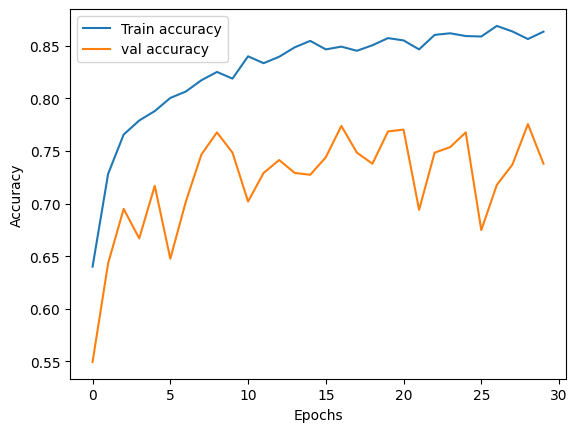

In [24]:
plt.plot(history.history['accuracy'], label = 'Train accuracy')
plt.plot(history.history['val_accuracy'], label = 'val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = 'best')
plt.show()

In [25]:
model.save("Brain_Tumor_1.h5")